In [2]:
# this will be the main script for the finalized project

from import_setup import *
from electrolysis import *
from methanation import *
from wwtp import *


# TODO: in the future, these variables can also be handled by a separate function/script
# for easier handling, different dataframes are created for the most needed quantities
# for type safety, the variables extracted from df are all specified as float arrays
# variables that are written into a new line every timestep
time_arr = df["Time / h"].values.astype(float)
time_diff = df["Time_diff / h"].values.astype(float)
raw_price = df["Price / EURO/MWh"].values.astype(float)
gas_production = df["Gas Production / Nm^3/h"].values.astype(float)
heat_demand_fermenter = df["Fermenter Heat Demand / kW"].values.astype(float)
chp_run_time = np.ones((time_arr.shape[0], num_chps))
chp_load = np.zeros((time_arr.shape[0], num_chps))
chp_el_power = np.zeros((time_arr.shape[0], num_chps))
chp_th_power = np.zeros((time_arr.shape[0], num_chps))
chp_gas_consumption = np.zeros((time_arr.shape[0], num_chps))
maintenance = np.zeros((time_arr.shape[0], num_chps))
maintenance_time_per_rule = np.zeros((time_arr.shape[0], num_chps, num_maintenance_rules))
gas_storage = np.zeros(time_arr.shape)
flare_run_time = np.zeros(time_arr.shape[0])
flare_gas_consumption = np.zeros(time_arr.shape[0])
temp_heat_net = np.zeros(time_arr.shape[0])
boiler_load = np.zeros((time_arr.shape[0], num_boilers))
boiler_th_power = np.zeros((time_arr.shape[0], num_boilers))
boiler_run_time = np.zeros((time_arr.shape[0], num_boilers))
boiler_gas_consumption = np.zeros((time_arr.shape[0], num_boilers))

# variables that are overwritten every timestep
run_time_between_maintenance = np.zeros([num_chps, chp_maintenance_rules.shape[1]], dtype=float)
maintenance_remaining_failure = np.zeros(num_chps, dtype=float)



# initialize operator
from load_scheduler import *
operator = LoadScheduler(flare_threshold, chp_gas_storage_rules, chp_maintenance_rules, chps, boilers, heat_net, price_threshold=80)
gas_storage[0] = 2402.79 # Nm^3
temp_heat_net[0] = 70 # °C

In [3]:
from loop import *

logging.debug("Starting simulation")
# Start the stopwatch
tic = time.time()

time_arr, chp_run_time, maintenance, chp_load, maintenance_time_per_rule, flare_run_time, flare_gas_consumption, gas_storage, time_diff, raw_price, maintenance_remaining_failure, num_chps, chp_el_power, chp_th_power, chp_gas_consumption, gas_production = \
    loop(time_arr, chp_run_time, maintenance, chp_load, maintenance_time_per_rule, flare_run_time, flare_gas_consumption, gas_storage, time_diff, raw_price, maintenance_remaining_failure, num_chps, chp_el_power, chp_th_power, chp_gas_consumption, gas_production, operator, chps, flare, biogas["h_u"])

# Stop the stopwatch
toc = time.time()

logging.info('Simulation took {:3.2f}s to compute, with {} steps'.format(toc-tic, len(time_arr)))

INFO:root:Simulation took 2.86s to compute, with 35044 steps


In [5]:
num_gas_storage_rules = np.count_nonzero(~np.isnan(chp_gas_storage_rules[:, :, 0]), axis=1)

In [6]:
from loop import *

@njit
def obj1_numba(x: List, time_arr: np.ndarray, chp_run_time: np.ndarray, maintenance: np.ndarray, chp_load: np.ndarray, maintenance_time_per_rule: np.ndarray, flare_run_time: np.ndarray, flare_gas_consumption: np.ndarray, gas_storage: np.ndarray, time_diff: np.ndarray, raw_price: np.ndarray, maintenance_remaining_failure: np.ndarray, num_chps: int, chp_el_power: np.ndarray, chp_th_power: np.ndarray, chp_gas_consumption: np.ndarray, gas_production: np.ndarray, operator, chps, flare, biogas_h_u: float):
    new_rules=np.copy(chp_gas_storage_rules)
    
    for i in range(num_chps):
        # for j in range(num_gas_storage_rules[i]):
        # x[i*num_gas_storage_rules[i] + 0]
        new_rules[i,0,0] = x[i]
        # new_rules[i,0,1] = chp_gas_storage_rules[i,0,1]
    
    operator.set_gas_storage_rules(new_rules)
    # operator.set_maintenance_rules(chp_maintenance_rules)
    flare_gas_cons_sum = 0
    num_reps = 10
    for i in range(num_reps):
        flare_gas_consumption = np.zeros(time_arr.shape[0])
        
        _,chp_run_time,_,chp_load,_,_, flare_gas_consumption,_,_,_,_,_,_,_,_,_ = \
        loop(time_arr, chp_run_time, maintenance, chp_load, maintenance_time_per_rule, flare_run_time, flare_gas_consumption, gas_storage, time_diff, raw_price, maintenance_remaining_failure, num_chps, chp_el_power, chp_th_power, chp_gas_consumption, gas_production, operator, chps, flare, biogas_h_u)

        flare_gas_cons_sum += np.sum(flare_gas_consumption)

        # print(chp_load.sum(axis=None))
    # return the value being minimized
    return flare_gas_cons_sum

In [14]:
bounds = List()
for i in range(num_chps):
    for j in range(num_gas_storage_rules[i]):
        bounds.append(List([100,1500]))

args = (time_arr, chp_run_time, maintenance, chp_load, maintenance_time_per_rule, flare_run_time, flare_gas_consumption, gas_storage, time_diff, raw_price, maintenance_remaining_failure, num_chps, chp_el_power, chp_th_power, chp_gas_consumption, gas_production, operator, chps, flare, biogas["h_u"])

x0 = List([101.81847501,  101.81847501,  175.31251231,  109.52160691,  452.60648146,  452.60648146, 1199.98869305,  520.84258546])

constr1 = {'type': 'ineq', 'fun': lambda x: x[0]- x[1]}
constr2 = {'type': 'ineq', 'fun': lambda x: x[2]- x[3]}
constr3 = {'type': 'ineq', 'fun': lambda x: x[4]- x[5]}
constr4 = {'type': 'ineq', 'fun': lambda x: x[6]- x[7]}
constraints = (constr1, constr2, constr3, constr4)

maxiter = 1500
logging.debug(f"Starting optimization with {maxiter} iterations")
# Start the stopwatch
tic = time.time()
result_set = dual_annealing(obj1_numba, bounds=bounds, args=args, maxiter=maxiter, seed=42, x0=x0, local_search_options={'method': 'SLSQP', 'constraints': constraints})
# result_set = dual_annealing(obj1_numba, bounds=bounds, args=args, maxiter=maxiter, seed=42, x0=x0, no_local_search=True)

# Stop the stopwatch
toc = time.time()

logging.info('Optimization took {:3.2f}s to compute, with {:3.2f} s/iter. Min. cost was {}'.format(toc-tic, (toc-tic)/maxiter, result_set.fun))

INFO:root:Optimization took 23146.95s to compute, with 15.43 s/iter. Min. cost was 12818318.892439747


In [15]:
result_set

     fun: 12818318.892439747
 message: ['Maximum number of iteration reached']
    nfev: 24665
    nhev: 0
     nit: 1500
    njev: 50
  status: 0
 success: True
       x: array([102.82155569, 101.79055907, 175.0071689 , 112.52973947,
       444.47402153, 795.6197746 , 111.91874668, 215.68786408])

Stats:
```
At 1 iteration:         Optimization took 12.14s to compute, with 12.14 s/iter. Min. cost was 9912497.956298022
At 10 iterations:       Optimization took 777.81s to compute, with 77.78 s/iter. Min. cost was 9549102.469838645
At 100 iterations:      
At 1000 iterations:     Optimization took 11035.75s to compute, with 11.04 s/iter. Min. cost was 9471461.212733999

At 1500 iters with constr.: Optimization took 23146.95s to compute, with 15.43 s/iter. Min. cost was 12818318.892439747
```


At 1000 iterations w/o constraints and no searching for local optima
```
fun: 9471461.212733999
 message: ['Maximum number of iteration reached']
    nfev: 16001
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([ 101.71682638,  116.07180409,  122.37463943,  158.43028215,
        349.69055823,  853.5347848 , 1237.81032924, 1270.13956348])
```

at 500 iterations with constraints
```
     fun: 12837842.128815543
 message: ['Maximum number of iteration reached']
    nfev: 8904
    nhev: 0
     nit: 500
    njev: 68
  status: 0
 success: True
       x: array([ 112.04951542,  177.21717377,  148.33586221,  103.32571301,
        528.06942306, 1446.5899473 , 1483.36229713, 1411.41738167])
```
after another 500 iterations with constraints
```
     fun: 12819210.567464823
 message: ['Maximum number of iteration reached']
    nfev: 8656
    nhev: 0
     nit: 500
    njev: 41
  status: 0
 success: True
       x: array([ 101.81847501,  105.01424706,  175.31251231,  109.52160691,
        452.60648146,  462.18996782, 1199.98869305,  520.84258546])
```
after another 1500 iterations with constraints
```
     fun: 12818318.892439747
 message: ['Maximum number of iteration reached']
    nfev: 24665
    nhev: 0
     nit: 1500
    njev: 50
  status: 0
 success: True
       x: array([102.82155569, 101.79055907, 175.0071689 , 112.52973947,
       444.47402153, 795.6197746 , 111.91874668, 215.68786408])
```

In [44]:
new_rules=np.zeros(chp_gas_storage_rules.shape)

for i in range(num_chps):
    for j in range(num_gas_storage_rules[i]):
        new_rules[i,j,0] = result_set.x[i*num_gas_storage_rules[i] + j]
        new_rules[i,j,2] = chp_gas_storage_rules[i,j,2]
new_rules

array([[[1.38907744e+02, 1.00000000e+00],
        [1.18335695e+03, 5.40000000e-01]],

       [[1.11038330e+02, 1.00000000e+00],
        [6.38956061e+02, 5.40000000e-01]],

       [[2.19835454e+02, 1.00000000e+00],
        [6.61308649e+02, 5.50000000e-01]],

       [[3.13906419e+02, 1.00000000e+00],
        [7.48426935e+02, 5.50000000e-01]]])

for 1 iteration with constraints:

```
     fun: 9863923.081674155
 message: ['Maximum number of iteration reached']
    nfev: 862
    nhev: 0
     nit: 1
    njev: 0
  status: 0
 success: True
       x: array([ 737.53453642,  737.53453642,  550.16727331,  150.52295997,
       1072.33959365, 1072.24771894, 1377.08176787, 1177.08142348])
```
for 10 iterations with constraints:
```
     fun: 9540635.067632027
 message: ['Maximum number of iteration reached']
    nfev: 4956
    nhev: 0
     nit: 10
    njev: 0
  status: 0
 success: True
       x: array([ 228.22124075,  227.02159235,  133.60579371,  133.40416447,
       1157.73539918,  335.04171554,  443.11763311,  442.83625294])
```
for 100 iterations with x0:

```
fun: 4283572076134.9307
 message: ['Maximum number of iteration reached']
    nfev: 1610
    nhev: 0
     nit: 100
    njev: 1
  status: 0
 success: True
       x: array([1200.,  800., 1200.,  800.,  500.,  400., 1000.,  800.])
```

In [86]:
result_set

     fun: 9541922.262550114
 message: ['Maximum number of iteration reached']
    nfev: 197
    nhev: 0
     nit: 10
    njev: 4
  status: 0
 success: True
       x: array([ 190.66558487,  263.79471912,  190.33198047,  111.49198543,
       1076.69479052,  738.05635005,  416.33172803, 1138.05635005])

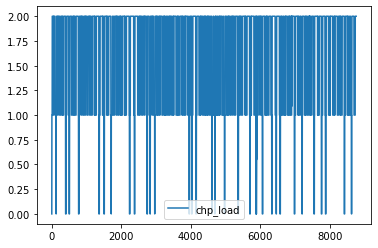

In [20]:
import matplotlib.pyplot as plt
# %matplotlib widget
# plt.plot(raw_price[:])
# plt.plot(time_arr, run_time.sum(axis=1), label="running")
# plt.plot(time_arr, maintenance.sum(axis=1), label="maintenance")
# plt.plot(time_arr, gas_storage[:], label="gas storage")
# plt.plot(time_arr, chp_el_power.sum(axis=1), label="chp_el_power")
# plt.plot(time_arr, chp_th_power.sum(axis=1), label="chp_th_power")
# plt.plot(time_arr, gas_production[:], label="gas_production")
# plt.plot(time_arr, chp_gas_consumption.sum(axis=1), label="chp_gas_consumption")
# plt.plot(time_arr, flare_gas_consumption, label="flare_gas_consumption")
plt.plot(time_arr, chp_load.sum(axis=1), label="chp_load")
plt.legend()

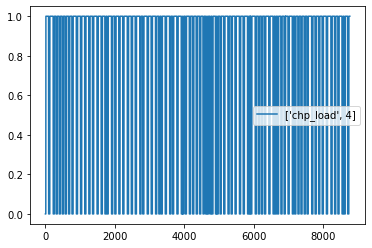

In [30]:
plt.plot(time_arr, chp_load[:,0], label=["chp_load", 1])
plt.plot(time_arr, chp_load[:,3], label=["chp_load", 4])
plt.legend()

In [24]:
new_rules=np.zeros(chp_gas_storage_rules.shape)
new_rules.shape
num_gas_storage_rules
num_chps
result_set

     fun: 4283572076134.9307
 message: ['Maximum number of iteration reached']
    nfev: 1610
    nhev: 0
     nit: 100
    njev: 1
  status: 0
 success: True
       x: array([1200.,  800., 1200.,  800.,  500.,  400., 1000.,  800.])

In [20]:

new_rules=np.zeros(chp_gas_storage_rules.shape)

for i in range(num_chps):
    for j in range(num_gas_storage_rules[i]):
        new_rules[i,j,0] = result_set.x[i*num_gas_storage_rules[i] + j]
        new_rules[i,j,1] = chp_gas_storage_rules[i,j,1]

new_rules


array([[[6.24356166e+02, 1.00000000e+00],
        [1.43100003e+03, 5.40000000e-01]],

       [[1.12479152e+03, 1.00000000e+00],
        [9.38121878e+02, 5.40000000e-01]],

       [[3.18426097e+02, 1.00000000e+00],
        [3.18392328e+02, 5.50000000e-01]],

       [[1.81317057e+02, 1.00000000e+00],
        [1.31264660e+03, 5.50000000e-01]]])